In [2]:
import pandas as pd
import numpy as np
import os

import logging
logging.getLogger().setLevel(logging.INFO)

from alphabase.spectral_library.flat import SpecLibFlat
from alphabase.spectral_library.base import SpecLibBase
from alphabase.spectral_library.reader import LibraryReaderBase
from alphadia.extraction.utils import reannotate_fragments
from alphabase.psm_reader import psm_reader_provider

INFO:root:


In [2]:
import warnings 

def fragment_number(precursor_df, fragment_intensity_df) :
    if not set(['frag_start_idx', 'frag_stop_idx']).issubset(precursor_df.columns):
        warnings.warn('frag_start_idx and frag_stop_idx not in dataframe')
        return
    
    n_fragments = []
    
    for start, stop in zip(precursor_df['frag_start_idx'].values, precursor_df['frag_stop_idx'].values):
        n_fragments += [np.sum(fragment_intensity_df.iloc[start:stop].values > 0)]

    precursor_df['n_fragments'] = n_fragments

In [3]:
lib_location = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/libraries/patricia_hela/21min_Evosep_HeLa_BR14_48fractions_diaPASEF_py_diAID_2.tsv'
#insilico_lib_location = '/Users/georgwallmann/Documents/data/libraries/2022_111_brunner_2022_1ng_all_29_human_trypsin_diann_decoy.hdf'


In [4]:
# create dense library from diann psm file
target_lib = LibraryReaderBase()
target_lib.import_file(lib_location)

#target_lib._fragment_mz_df = target_lib._fragment_mz_df[['b_z1', 'b_z2', 'y_z1', 'y_z2']]
#target_lib._fragment_intensity_df = target_lib._fragment_intensity_df[['b_z1', 'b_z2', 'y_z1', 'y_z2']]

#target_lib._precursor_df['elution_group_idx'] = np.arange(len(target_lib._precursor_df))

/Users/georgwallmann/Documents/git/alphabase/alphabase/spectral_library/reader.py:250: DtypeWarning: Columns (33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, sep=self.csv_sep)


,precursor_mz,sequence,proteins,mods,mobility,mod_sites,raw_name,nAA,charge,rt,uniprot_ids,genes,frag_start_idx,frag_stop_idx,rt_norm,ccs
0,350.160274,FSETHADPHNSR,SCD_HUMAN,,0.716,,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,12,4,-46.086216,O00767,SCD,0,11,-0.305844,579.219649
1,350.173741,LGMGHCFVK,CTR9_HUMAN,Carbamidomethyl@C,0.735,6,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,9,3,4.169581,Q6PD62,CTR9,11,19,0.029924,447.396582
2,350.177195,LHEDHLER,EXOS4_HUMAN,,0.719,,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,8,3,-44.444714,Q9NPD3,EXOSC4,19,26,-0.292227,437.657280
3,350.178319,TDRLEVCR,MBNL1_HUMAN,Carbamidomethyl@C,0.716,7,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,8,3,-24.287659,Q9NR56,MBNL1,26,33,-0.163675,435.831154
4,350.185579,VSYSHIQSK,MAP4_HUMAN,,0.728,,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,9,3,-32.200010,P27816,MAP4,33,41,-0.212722,443.135467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235305,1198.566686,VAEPELMGTPDGTCYPPPPVPR,PYR1_HUMAN,Oxidation@M;Carbamidomethyl@C,1.262,7;14,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,22,2,46.349000,P27708,CAD,3084841,3084862,0.300391,508.373848
235306,1198.570383,FISGSMAGATAQTFIYPMEVMK,SCMC1_HUMAN,Oxidation@M,1.274,6,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,22,2,90.234510,Q6NUK1,SLC25A24,3084862,3084883,0.608092,513.207821
235307,1198.588141,YMNSLLIGELSPEQPSFEPTK,FADS1_HUMAN,Oxidation@M,1.242,2,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,21,2,79.461590,O60427,FADS1,3084883,3084903,0.409142,500.317158
235308,1199.256104,KLDDQSEDEALELEGPLITPGSGSIYSSPGLYSK,FERM2_HUMAN,,1.101,,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,34,3,87.989990,Q96AC1,FERMT2,3084903,3084936,0.552136,663.993973


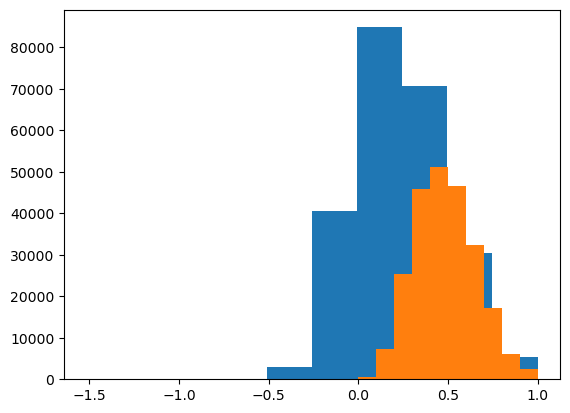

In [5]:
import matplotlib.pyplot as plt
_ = plt.hist(target_lib._precursor_df['rt_norm'])
target_lib.precursor_df = target_lib.precursor_df[target_lib.precursor_df['rt_norm'] > -0.5].copy()

# scale rt_norm to from min max to 0-1
target_lib.precursor_df['rt_norm'] = (target_lib.precursor_df['rt_norm'] - target_lib.precursor_df['rt_norm'].min())/(target_lib.precursor_df['rt_norm'].max() - target_lib.precursor_df['rt_norm'].min())
_ = plt.hist(target_lib._precursor_df['rt_norm'])

In [6]:
target_lib._precursor_df['decoy'] = 0

In [7]:
target_lib._precursor_df['elution_group_idx'] = np.arange(len(target_lib._precursor_df))
fragment_number(target_lib.precursor_df, target_lib._fragment_intensity_df)

In [8]:
decoy_lib = SpecLibBase()
decoy_lib._precursor_df = target_lib.precursor_df.copy()
decoy_lib._fragment_mz_df = target_lib._fragment_mz_df.copy()
decoy_lib._fragment_intensity_df = target_lib._fragment_intensity_df.copy()

#decoy_lib.import_file(brunner_lib)
decoy_lib.decoy = 'diann'
decoy_lib.append_decoy_sequence()
decoy_lib.calc_precursor_mz()
decoy_lib.precursor_df = decoy_lib.precursor_df[decoy_lib.precursor_df['decoy'] == 1]

In [9]:
from peptdeep.pretrained_models import ModelManager
from alphabase.peptide.fragment import get_charged_frag_types

frag_types = get_charged_frag_types(
    ['b','y','b_modloss', 'y_modloss'], 
    2
)

model_mgr = ModelManager()

model_mgr.nce = 30
model_mgr.instrument = 'timsTOF'

In [10]:
res = model_mgr.predict_all(
    decoy_lib.precursor_df,
    predict_items=['ms2'],
    frag_types = frag_types,
)

decoy_lib._precursor_df = res['precursor_df']
decoy_lib._fragment_mz_df = res['fragment_mz_df']
decoy_lib._fragment_intensity_df = res['fragment_intensity_df']

2023-03-06 20:10:28> Using multiprocessing with 8 processes ...
2023-03-06 20:10:28> Predicting ms2 ...


100%|██████████| 46/46 [00:48<00:00,  1.06s/it]


In [11]:
decoy_lib._precursor_df[['frag_start_idx']] += len(target_lib._fragment_mz_df)
decoy_lib._precursor_df[['frag_stop_idx']] += len(target_lib._fragment_mz_df)

In [12]:
output_lib = SpecLibBase()

output_lib._precursor_df = pd.concat([target_lib._precursor_df, decoy_lib._precursor_df], join='inner')
output_lib._fragment_mz_df = pd.concat([target_lib._fragment_mz_df, decoy_lib._fragment_mz_df], join='inner')
output_lib._fragment_intensity_df = pd.concat([target_lib._fragment_intensity_df, decoy_lib._fragment_intensity_df], join='inner')

In [13]:
output_lib._precursor_df = output_lib._precursor_df.sort_values(by=['genes']).reset_index(drop=True)
output_lib._precursor_df['precursor_idx'] = np.arange(len(output_lib.precursor_df))

In [14]:
output_lib.precursor_df

,precursor_mz,sequence,proteins,mods,mobility,mod_sites,raw_name,nAA,charge,rt,uniprot_ids,genes,frag_start_idx,frag_stop_idx,rt_norm,ccs,decoy,elution_group_idx,n_fragments,precursor_idx
0,722.933448,MLSGFIPLKPTLK,A2MG_HUMAN,,1.039,,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,13,2,46.246643,P01023,A2M,4394264,4394276,0.537908,420.207885,1,114071,11,0
1,923.022034,LLIYAVLPTGDVIGDSAK,A2MG_HUMAN,,1.193,,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,18,2,101.539480,P01023,A2M,2652763,2652780,0.780463,481.405937,0,184940,5,1
2,1031.050466,LLLQQVSLPELPGEYSMK,A2MG_HUMAN,Oxidation@M,1.209,17,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,18,2,94.278780,P01023,A2M,2917601,2917618,0.748410,487.480336,0,188912,6,2
3,509.800217,ATVLNYLPK,A2MG_HUMAN,,0.862,,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,9,2,51.729183,P01023,A2M,376185,376193,0.362176,349.938903,0,33628,7,3
4,942.527484,VSVQLEASPAFLAVPVEK,A2MG_HUMAN,,1.176,,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,18,2,85.071420,P01023,A2M,2712317,2712334,0.707763,474.472633,0,187040,13,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464658,551.944547,SIAHPEEISSNSQVR,ZZZ3_HUMAN,,0.882,,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,15,3,-6.967744,Q8IYH5,ZZZ3,602701,602715,0.301280,534.322196,0,157794,9,464658
464659,827.413182,SIAHPEEISSNSQVR,ZZZ3_HUMAN,,1.081,,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,15,2,-6.967744,Q8IYH5,ZZZ3,2269748,2269762,0.301280,436.587466,0,146068,7,464659
464660,817.727326,LSDDTKPETFNQLWTVEENK,ZZZ3_HUMAN,Carbamidomethyl@C,0.955,2,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,20,3,58.466866,Q8IYH5,ZZZ3,5557039,5557058,0.570251,576.941246,1,205751,7,464660
464661,806.375211,STVGLNGLDESFCGR,ZZZ3_HUMAN,Carbamidomethyl@C,1.061,13,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,15,2,50.331100,Q8IYH5,ZZZ3,2167737,2167751,0.536178,428.602989,0,152161,15,464661


In [15]:
for i, (start_idx, stop_idx, k_allowed) in enumerate(zip(output_lib.precursor_df['frag_start_idx'].values, output_lib.precursor_df['frag_stop_idx'].values,output_lib.precursor_df['n_fragments'].values)):
    intensies = output_lib._fragment_intensity_df.iloc[start_idx:stop_idx].values
    flat_intensities = np.sort(intensies.flatten())[::-1]
    output_lib._fragment_intensity_df.iloc[start_idx:stop_idx].values[intensies <= flat_intensities[k_allowed]] = 0


In [16]:
fragment_number(output_lib.precursor_df, output_lib._fragment_intensity_df)

<AxesSubplot:xlabel='n_fragments', ylabel='Count'>

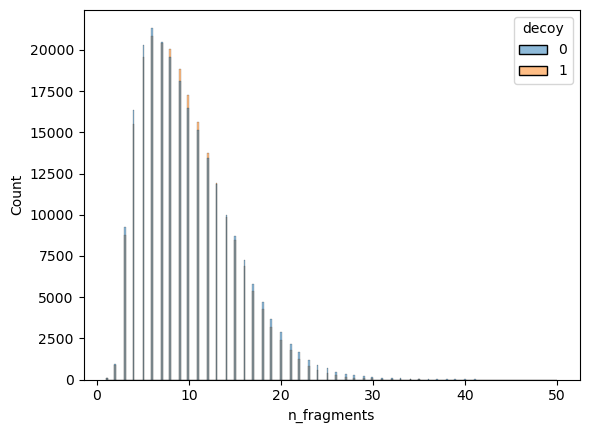

In [17]:
import seaborn as sns
sns.histplot(output_lib.precursor_df, x ='n_fragments', hue='decoy')

In [18]:
from tqdm import tqdm
from alphabase.peptide.precursor import get_mod_seq_formula
from alphabase.constants.isotope import IsotopeDistribution


def calc_isotope_dist(precursor_df, max_isotope = 6, min_intensity = 0.001):
    isotope_dist = IsotopeDistribution()

    col_names = ['i_{}'.format(i) for i in range(max_isotope)]
    precursor_df[col_names] = 0.

    for i in tqdm(range(len(precursor_df))):

        row = precursor_df.iloc[i]
        dist, mono = isotope_dist.calc_formula_distribution(
            get_mod_seq_formula(row['sequence'], row['mods'])
        )
        dist[dist < 0.001] = 0.
        dist = dist / dist.sum()
        precursor_df.loc[i, col_names] = dist[:max_isotope]

In [19]:
calc_isotope_dist(output_lib.precursor_df)

100%|██████████| 464663/464663 [02:55<00:00, 2652.35it/s]


In [20]:
output_lib._precursor_df.drop(columns=['rt'], inplace=True)

In [24]:
output_location = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/libraries/patricia_hela/21min_Evosep_HeLa_BR14_48fractions_diaPASEF_py_diAID_2.hdf'
output_lib.save_hdf(output_location)

In [22]:
res = model_mgr.predict_all(
    output_lib.precursor_df,
    predict_items=['ms2'],
    frag_types = frag_types,
)

output_lib._precursor_df = res['precursor_df']
output_lib._fragment_mz_df = res['fragment_mz_df']
output_lib._fragment_intensity_df = res['fragment_intensity_df']

2023-03-06 20:14:31> Using multiprocessing with 8 processes ...
2023-03-06 20:14:31> Predicting ms2 ...


100%|██████████| 46/46 [01:34<00:00,  2.06s/it]


In [23]:
fragment_number(output_lib.precursor_df, output_lib._fragment_intensity_df)

<AxesSubplot:xlabel='n_fragments', ylabel='Count'>

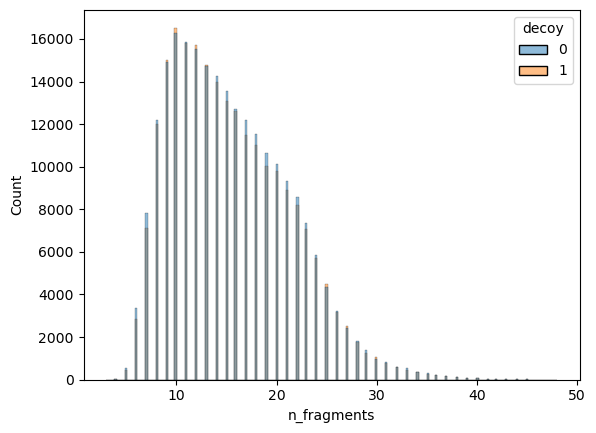

In [24]:
import seaborn as sns
sns.histplot(output_lib.precursor_df, x ='n_fragments', hue='decoy')

In [25]:
output_location = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/libraries/patricia_hela/21min_Evosep_HeLa_BR14_48fractions_diaPASEF_py_diAID_2_predicted.hdf'
output_lib.save_hdf(output_location)